In [1]:
import wikipedia, requests, random, pycm, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from IPython.display import display, Markdown
from classification_procedure import ClassificationProcedure

## Classification procedures

In [2]:
oed_planet = ClassificationProcedure(
    "OED",
    "planet", 
    """Any of various rocky or gaseous bodies that revolve in approximately elliptical orbits 
around the sun and are visible by its reflected light; esp. each of the planets Mercury, Venus, 
Earth, Mars, Jupiter, Saturn, Uranus, Neptune, and (until 2006) Pluto (in order of increasing 
distance from the sun); a similar body revolving around another star. Also: any of various 
smaller bodies that revolve around these (cf. satellite n. 2a).""",
    "https://www.oed.com/dictionary/planet_n"
)

iau_2006_8_16_planet = ClassificationProcedure(
    "IAU 2006-08-16",
    "planet", 
    """A planet is a celestial body that (a) has sufficient mass for its self-gravity to 
overcome rigid body forces so that it assumes a hydrostatic equilibrium (nearly round) shape, 
and (b) is in orbit around a star, and is neither a star nor a satellite of a planet.""",
    "https://www.iau.org/news/pressreleases/detail/iau0601/"
)

iau_2006_8_24_planet = ClassificationProcedure(
    "IAU 2006-08-24",
    "planet", 
    """A planet [1] is a celestial body that (a) is in orbit around the Sun, (b) has sufficient 
mass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic 
equilibrium (nearly round) shape, and (c) has cleared the neighbourhood around its orbit.""",
    "https://www.iau.org/static/resolutions/Resolution_GA26-5-6.pdf"
)

### Example in Figure 1

In [3]:
iau_2006_8_24_planet.classify("DENIS-P J082303.1−491201 b", "DENIS-P J082303.1-491201 b (alias 2MASS J08230313-4912012 b) is a substellar object, classified as either an exoplanet or a brown dwarf, orbiting DENIS-P J082303.1-491201, an L1.5-type brown dwarf in the constellation Vela.")

{'concept': 'planet',
 'definition': 'A planet [1] is a celestial body that (a) is in orbit around the Sun, (b) has sufficient \nmass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic \nequilibrium (nearly round) shape, and (c) has cleared the neighbourhood around its orbit.',
 'entity': 'DENIS-P J082303.1−491201 b',
 'description': 'DENIS-P J082303.1-491201 b (alias 2MASS J08230313-4912012 b) is a substellar object, classified as either an exoplanet or a brown dwarf, orbiting DENIS-P J082303.1-491201, an L1.5-type brown dwarf in the constellation Vela.',
 'rationale': 'The description of DENIS-P J082303.1−491201 b indicates that it is a substellar object that orbits DENIS-P J082303.1-491201, which is similar to the definition of a planet that states it is a celestial body in orbit around the Sun. Although the object in question is orbiting a brown dwarf and not the Sun, the concept is similar. However, the description does not provide information abou

## Wikidata queries

In [4]:
KNOWLEDGE_GRAPH = "https://query.wikidata.org/sparql"

QUERY_HEADERS = {
    'User-Agent': 'ConceptualEngineeringAgent/0.2 (https://github.com/bradleypallen/conceptual-engineering-using-llms; b.p.allen@uva.nl)',
}

SAMPLE_SIZE = 5

POSITIVE_EXAMPLES_QUERY = """SELECT DISTINCT ?entity ?name ?article WHERE {
  {
    ?entity p:P31/ps:P31/wdt:P279* wd:Q634 .
    ?article schema:about ?entity ;
            schema:inLanguage "en" ;
            schema:isPartOf <https://en.wikipedia.org/> ;
            schema:name ?name .
  }
} LIMIT 10000"""

NEGATIVE_EXAMPLES_QUERY = """SELECT DISTINCT ?entity ?name ?article WHERE {
  {
    ?entity p:P31/ps:P31/wdt:P279* wd:Q3132741 .
    ?article schema:about ?entity ;
            schema:inLanguage "en" ;
            schema:isPartOf <https://en.wikipedia.org/> ;
            schema:name ?name .
    FILTER NOT EXISTS { ?entity p:P31/ps:P31 wd:Q634 }
  }
} LIMIT 10000"""

## Example entities

In [5]:
response = requests.get(KNOWLEDGE_GRAPH, params={'query' : POSITIVE_EXAMPLES_QUERY, 'format' : 'json'}, headers=QUERY_HEADERS)
response.raise_for_status()
json = response.json()
records = [ [ result["entity"]["value"], result["name"]["value"], result["article"]["value"] ] for result in json["results"]["bindings"] ]
records = random.sample(records, SAMPLE_SIZE)
positive_examples = pd.DataFrame.from_records(records, columns=["id", "name", "article"])
positive_examples["description"] = positive_examples["name"].apply(lambda name: wikipedia.summary(name, auto_suggest=False).replace('"', r'\"').strip()) 
positive_examples["actual"] = "positive"

In [6]:
response = requests.get(KNOWLEDGE_GRAPH, params={'query' : NEGATIVE_EXAMPLES_QUERY, 'format' : 'json'}, headers=QUERY_HEADERS)
response.raise_for_status()
json = response.json()
records = [ [ result["entity"]["value"], result["name"]["value"], result["article"]["value"] ] for result in json["results"]["bindings"] ]
records = random.sample(records, SAMPLE_SIZE)
negative_examples = pd.DataFrame.from_records(records, columns=["id", "name", "article"])
negative_examples["description"] = negative_examples["name"].apply(lambda name: wikipedia.summary(name, auto_suggest=False).replace('"', r'\"').strip()) 
negative_examples["actual"] = "negative"

In [7]:
examples = pd.concat([positive_examples, negative_examples], ignore_index=True)
examples

,id,name,article,description,actual
0,http://www.wikidata.org/entity/Q18613722,Kepler-32d,https://en.wikipedia.org/wiki/Kepler-32d,Kepler-32 is an M-type main sequence star loca...,positive
1,http://www.wikidata.org/entity/Q79739084,HD 109271 b,https://en.wikipedia.org/wiki/HD_109271_b,HD 109271 is a star in the constellation of Vi...,positive
2,http://www.wikidata.org/entity/Q637135,Gliese 667 Cc,https://en.wikipedia.org/wiki/Gliese_667_Cc,"Gliese 667 Cc (also known as GJ 667Cc, HR 6426...",positive
3,http://www.wikidata.org/entity/Q56670425,40 Eridani Ab,https://en.wikipedia.org/wiki/40_Eridani_Ab,40 Eridani is a triple star system in the cons...,positive
4,http://www.wikidata.org/entity/Q94498521,HD 158259 c,https://en.wikipedia.org/wiki/HD_158259_c,HD 158259 is a main sequence star located 88 l...,positive
5,http://www.wikidata.org/entity/Q3498380,121P/Shoemaker–Holt,https://en.wikipedia.org/wiki/121P/Shoemaker%E...,"121P/Shoemaker–Holt, also known as Shoemaker-H...",negative
6,http://www.wikidata.org/entity/Q106348295,TOI-1601 b,https://en.wikipedia.org/wiki/TOI-1601_b,TOI-1601 b is an exoplanet that was discovered...,negative
7,http://www.wikidata.org/entity/Q1627089,7693 Hoshitakuhai,https://en.wikipedia.org/wiki/7693_Hoshitakuhai,The following is a partial list of minor plane...,negative
8,http://www.wikidata.org/entity/Q2623637,13540 Kazukitakahashi,https://en.wikipedia.org/wiki/13540_Kazukitaka...,The following is a partial list of minor plane...,negative
9,http://www.wikidata.org/entity/Q619618,6479 Leoconnolly,https://en.wikipedia.org/wiki/6479_Leoconnolly,The following is a partial list of minor plane...,negative


## Experiments

In [8]:
def run_experiment(cp, examples):
    classifications = examples.to_dict("records")
    for entity in tqdm(classifications):
        classification = cp.classify(entity["name"], entity["description"])
        entity["rationale"] = classification["rationale"]
        entity["predicted"] = classification["answer"]
    return pd.DataFrame.from_records(classifications)

In [9]:
oed_planet_results = run_experiment(oed_planet, examples)

100%|██████████| 10/10 [01:19<00:00,  7.96s/it]


In [10]:
iau_2006_8_16_planet_results = run_experiment(iau_2006_8_16_planet, examples)

100%|██████████| 10/10 [01:27<00:00,  8.77s/it]


In [11]:
iau_2006_8_24_planet_results = run_experiment(iau_2006_8_24_planet, examples)

100%|██████████| 10/10 [01:34<00:00,  9.42s/it]


## Performance metrics

In [12]:
oed_planet_cm = pycm.ConfusionMatrix(
    oed_planet_results["actual"].tolist(), 
    oed_planet_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

iau_2006_8_16_planet_cm = pycm.ConfusionMatrix(
    iau_2006_8_16_planet_results["actual"].tolist(), 
    iau_2006_8_16_planet_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

iau_2006_8_24_planet_cm = pycm.ConfusionMatrix(
    iau_2006_8_24_planet_results["actual"].tolist(), 
    iau_2006_8_24_planet_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

In [13]:
cms = [
    (f'{oed_planet.term} ({oed_planet.id})', oed_planet_cm),
    (f'{iau_2006_8_16_planet.term} ({iau_2006_8_16_planet.id})', iau_2006_8_16_planet_cm),
    (f'{iau_2006_8_24_planet.term} ({iau_2006_8_24_planet.id})', iau_2006_8_24_planet_cm)
]

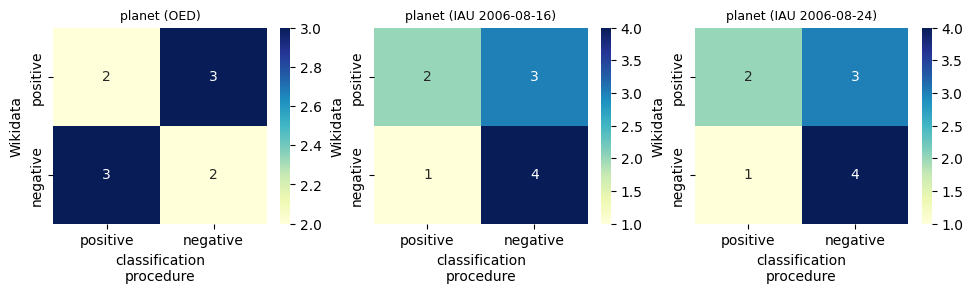

In [14]:
fig = plt.figure(figsize=(20,14))
gs = fig.add_gridspec(4, 5, hspace=0.5)
axes = gs.subplots()
for ax, (name, cm) in zip(axes.flat, cms):
    df = pd.DataFrame(cm.matrix).T.fillna(0)
    sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", ax=ax)
    ax.set_title(name, wrap=True, fontsize=9)
    ax.set(xlabel='classification\nprocedure', ylabel='Wikidata')
for ax in axes.flat[len(cms):]:
    ax.set_visible(False)
plt.show()

In [15]:
metrics = pd.DataFrame.from_records([ 
    { "classification procedure": cm[0], "Cohen's kappa": cm[1].Kappa, "F1 macro": cm[1].F1_Macro, "FN": cm[1].FN["positive"], "FP": cm[1].FP["positive"] }
    for cm in cms 
])
metrics.sort_values(by="Cohen's kappa", ascending=False)

,classification procedure,Cohen's kappa,F1 macro,FN,FP
1,planet (IAU 2006-08-16),0.2,0.583333,3,1
2,planet (IAU 2006-08-24),0.2,0.583333,3,1
0,planet (OED),-0.2,0.400000,3,3


## Error analyses

In [16]:
def display_errors(cp, results):
    display(Markdown(f'### {cp.term} ({cp.id})'))
    display(Markdown(f'#### Definition'))
    display(Markdown(f'{cp.definition}'))
    fns = results[((results["actual"] == 'positive') & (results["predicted"] == 'negative'))][["name", "description", "rationale"]]
    if len(fns) > 0:
        fns_styler = fns.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown(f'#### False negatives'))
        display(fns_styler)
    fps = results[((results["actual"] == 'negative') & (results["predicted"] == 'positive'))][["name", "description", "rationale"]]
    if len(fps) > 0:
        fps_styler = fps.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown(f'#### False positives'))
        display(fps_styler)


In [17]:
display_errors(oed_planet, oed_planet_results)

### planet (OED)

#### Definition

Any of various rocky or gaseous bodies that revolve in approximately elliptical orbits 
around the sun and are visible by its reflected light; esp. each of the planets Mercury, Venus, 
Earth, Mars, Jupiter, Saturn, Uranus, Neptune, and (until 2006) Pluto (in order of increasing 
distance from the sun); a similar body revolving around another star. Also: any of various 
smaller bodies that revolve around these (cf. satellite n. 2a).

#### False negatives

name,description,rationale
Kepler-32d,"Kepler-32 is an M-type main sequence star located about 1070 light years from Earth, in the constellation of Cygnus. Discovered in January 2012 by the Kepler spacecraft, it shows a 0.58 ± 0.05 solar mass (M☉), a 0.53 ± 0.04 solar radius (R☉), and temperature of 3900.0 K, making it half the mass and radius of the Sun, two-thirds its temperature and 5% its luminosity.","The provided description does not provide sufficient information to assert that Kepler-32d is a planet. The description details the characteristics of Kepler-32, a star, but does not provide any information about Kepler-32d revolving around this star or any other star, which is a necessary characteristic of a planet according to the provided definition. Therefore, based on the given information, we cannot assert that Kepler-32d is a planet."
HD 109271 b,"HD 109271 is a star in the constellation of Virgo. With an apparent magnitude of 8.05, it cannot be seen with the naked eye. Parallax measurements made by Gaia put the star at a distance of 182 light-years (56.0 parsecs) away.HD 109271 is a typical G-type main-sequence star. It has a mass of 1.047 M☉, but is twice as luminous as the Sun. It is also much older, at an age of 7.3 billion years.In 2020, a red dwarf companion of 0.6M☉ was found orbiting HD 109271 at projected separation 304 AU.","The description of HD 109271 b does not provide sufficient information to assert that it is a planet. The description mentions that HD 109271 b is a red dwarf companion, which indicates that it is a star, not a planet. The definition of a planet states that it is a rocky or gaseous body that revolves around the sun or another star, and is visible by its reflected light. The description of HD 109271 b does not meet these criteria. Therefore, based on the provided definition and description, we cannot assert that HD 109271 b is a planet."
40 Eridani Ab,"40 Eridani is a triple star system in the constellation of Eridanus, abbreviated 40 Eri. It has the Bayer designation Omicron2 Eridani, which is Latinized from ο2 Eridani and abbreviated Omicron2 Eri or ο2 Eri. Based on parallax measurements taken by the Gaia mission, it is about 16.3 light-years from the Sun. The primary star of the system, designated 40 Eridani A and named Keid, is easily visible to the naked eye. It is orbited by a binary pair whose two components are designated 40 Eridani B and C, and which were discovered on January 31, 1783, by William Herschel.: p73 It was again observed by Friedrich Struve in 1825 and by Otto Struve in 1851.In 1910, it was discovered that although component B was a faint star, it was white in color. This meant that it had to be a small star; in fact it was a white dwarf, the first discovered. Although it is neither the closest white dwarf, nor the brightest in the night sky, it is by far the easiest to observe; it is nearly three magnitudes brighter than Van Maanen's Star, the nearest solitary white dwarf, and unlike the companions of Procyon and Sirius it is not swamped in the glare of a much brighter primary.","The text does not provide sufficient information to assert that 40 Eridani Ab is a planet. The text describes 40 Eridani as a triple star system, with the primary star being 40 Eridani A, and the other two components being 40 Eridani B and C. However, there is no mention of a body that revolves around these stars in an elliptical orbit, which is the defining characteristic of a planet according to the provided definition. Therefore, based on the given information, we cannot conclude that 40 Eridani Ab is a planet."


#### False positives

name,description,rationale
TOI-1601 b,TOI-1601 b is an exoplanet that was discovered by TESS in January 2021. It has an orbital period of 5.3 days and is located 1098 light years away from Earth. It also has a mass similar to that of Jupiter.,"TOI-1601 b fits the definition of a planet as it is a body that revolves in an orbit, specifically around a star. This is evidenced by the information that it has an orbital period of 5.3 days. Furthermore, it is similar to Jupiter, which is one of the planets listed in the definition, in terms of mass. Therefore, based on the provided definition, TOI-1601 b can be classified as a planet."
7693 Hoshitakuhai,"The following is a partial list of minor planets, running from minor-planet number 7001 through 8000, inclusive. The primary data for this and other partial lists is based on JPL's \""Small-Body Orbital Elements\"" and \""Data Available from the Minor Planet Center\"". A detailed description of the table's columns and additional sources are given on the main page including a complete list of every page in this series, and a statistical break-up on the dynamical classification of minor planets. Also see the summary list of all named bodies in numerical and alphabetical order, and the corresponding naming citations for the number range of this particular list. New namings may only be added to this list after official publication, as the preannouncement of names is condemned by the Working Group for Small Bodies Nomenclature of the International Astronomical Union.","The definition of a planet includes any of various rocky or gaseous bodies that revolve in approximately elliptical orbits around the sun and are visible by its reflected light. It also includes any of various smaller bodies that revolve around these. The description of 7693 Hoshitakuhai indicates that it is a minor planet, which falls under the category of smaller bodies that revolve around the sun. Therefore, based on the given definition, one could argue that 7693 Hoshitakuhai is a planet."
6479 Leoconnolly,"The following is a partial list of minor planets, running from minor-planet number 6001 through 7000, inclusive. The primary data for this and other partial lists is based on JPL's \""Small-Body Orbital Elements\"" and \""Data Available from the Minor Planet Center\"". A detailed description of the table's columns and additional sources are given on the main page including a complete list of every page in this series, and a statistical break-up on the dynamical classification of minor planets. Also see the summary list of all named bodies in numerical and alphabetical order, and the corresponding naming citations for the number range of this particular list. New namings may only be added to this list after official publication, as the preannouncement of names is condemned by the Working Group for Small Bodies Nomenclature of the International Astronomical Union.","The definition of a planet includes any of various rocky or gaseous bodies that revolve in approximately elliptical orbits around the sun and are visible by its reflected light. The entity 6479 Leoconnolly is listed as a minor planet, which implies that it is a smaller body that revolves around the sun. Therefore, based on the provided definition, one could argue that 6479 Leoconnolly is a planet."


In [18]:
display_errors(iau_2006_8_16_planet, iau_2006_8_16_planet_results)

### planet (IAU 2006-08-16)

#### Definition

A planet is a celestial body that (a) has sufficient mass for its self-gravity to 
overcome rigid body forces so that it assumes a hydrostatic equilibrium (nearly round) shape, 
and (b) is in orbit around a star, and is neither a star nor a satellite of a planet.

#### False negatives

name,description,rationale
Kepler-32d,"Kepler-32 is an M-type main sequence star located about 1070 light years from Earth, in the constellation of Cygnus. Discovered in January 2012 by the Kepler spacecraft, it shows a 0.58 ± 0.05 solar mass (M☉), a 0.53 ± 0.04 solar radius (R☉), and temperature of 3900.0 K, making it half the mass and radius of the Sun, two-thirds its temperature and 5% its luminosity.","The text does not provide enough information to assert that Kepler-32d is a planet. The description given refers to Kepler-32, which is a star, not a planet. There is no information provided about Kepler-32d, its shape, its orbit, or its relationship to any star or planet. Therefore, based on the provided information, we cannot classify Kepler-32d as a planet."
HD 109271 b,"HD 109271 is a star in the constellation of Virgo. With an apparent magnitude of 8.05, it cannot be seen with the naked eye. Parallax measurements made by Gaia put the star at a distance of 182 light-years (56.0 parsecs) away.HD 109271 is a typical G-type main-sequence star. It has a mass of 1.047 M☉, but is twice as luminous as the Sun. It is also much older, at an age of 7.3 billion years.In 2020, a red dwarf companion of 0.6M☉ was found orbiting HD 109271 at projected separation 304 AU.","The provided description does not provide sufficient information to assert that HD 109271 b is a planet. The description mentions that HD 109271 b is a red dwarf companion of the star HD 109271, but it does not provide information about its shape or whether it orbits a star and is not a star itself or a satellite of a planet. Therefore, based on the provided information, we cannot conclude that HD 109271 b is a planet."
40 Eridani Ab,"40 Eridani is a triple star system in the constellation of Eridanus, abbreviated 40 Eri. It has the Bayer designation Omicron2 Eridani, which is Latinized from ο2 Eridani and abbreviated Omicron2 Eri or ο2 Eri. Based on parallax measurements taken by the Gaia mission, it is about 16.3 light-years from the Sun. The primary star of the system, designated 40 Eridani A and named Keid, is easily visible to the naked eye. It is orbited by a binary pair whose two components are designated 40 Eridani B and C, and which were discovered on January 31, 1783, by William Herschel.: p73 It was again observed by Friedrich Struve in 1825 and by Otto Struve in 1851.In 1910, it was discovered that although component B was a faint star, it was white in color. This meant that it had to be a small star; in fact it was a white dwarf, the first discovered. Although it is neither the closest white dwarf, nor the brightest in the night sky, it is by far the easiest to observe; it is nearly three magnitudes brighter than Van Maanen's Star, the nearest solitary white dwarf, and unlike the companions of Procyon and Sirius it is not swamped in the glare of a much brighter primary.","The provided description does not provide sufficient information to assert that 40 Eridani Ab is a planet. The description mentions that 40 Eridani is a triple star system, with the primary star being 40 Eridani A and the other two components being 40 Eridani B and C. However, there is no mention of a celestial body named 40 Eridani Ab. Furthermore, even if there was, the description does not provide information about its shape, its orbit, or whether it is a star or a satellite of a planet, which are necessary criteria for a celestial body to be considered a planet according to the provided definition. Therefore, based on the provided information, we cannot assert that 40 Eridani Ab is a planet."


#### False positives

name,description,rationale
TOI-1601 b,TOI-1601 b is an exoplanet that was discovered by TESS in January 2021. It has an orbital period of 5.3 days and is located 1098 light years away from Earth. It also has a mass similar to that of Jupiter.,"TOI-1601 b fits the definition of a planet because it is a celestial body that is in orbit around a star, as indicated by its discovery by TESS and its orbital period of 5.3 days. It is not a star itself, nor is it a satellite of a planet. Furthermore, its mass is similar to that of Jupiter, suggesting that it has sufficient mass for its self-gravity to overcome rigid body forces and assume a hydrostatic equilibrium shape. Therefore, based on the provided definition, TOI-1601 b can be classified as a planet."


In [19]:
display_errors(iau_2006_8_24_planet, iau_2006_8_24_planet_results)

### planet (IAU 2006-08-24)

#### Definition

A planet [1] is a celestial body that (a) is in orbit around the Sun, (b) has sufficient 
mass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic 
equilibrium (nearly round) shape, and (c) has cleared the neighbourhood around its orbit.

#### False negatives

name,description,rationale
Kepler-32d,"Kepler-32 is an M-type main sequence star located about 1070 light years from Earth, in the constellation of Cygnus. Discovered in January 2012 by the Kepler spacecraft, it shows a 0.58 ± 0.05 solar mass (M☉), a 0.53 ± 0.04 solar radius (R☉), and temperature of 3900.0 K, making it half the mass and radius of the Sun, two-thirds its temperature and 5% its luminosity.","The provided description does not provide sufficient information to assert that Kepler-32d is a planet. The description details the characteristics of Kepler-32, a star, but does not provide information about Kepler-32d's orbit around the Sun, its mass and shape, or whether it has cleared its orbit's neighbourhood. Therefore, based on the provided information, we cannot determine if Kepler-32d meets the criteria to be classified as a planet."
HD 109271 b,"HD 109271 is a star in the constellation of Virgo. With an apparent magnitude of 8.05, it cannot be seen with the naked eye. Parallax measurements made by Gaia put the star at a distance of 182 light-years (56.0 parsecs) away.HD 109271 is a typical G-type main-sequence star. It has a mass of 1.047 M☉, but is twice as luminous as the Sun. It is also much older, at an age of 7.3 billion years.In 2020, a red dwarf companion of 0.6M☉ was found orbiting HD 109271 at projected separation 304 AU.","The provided description does not provide sufficient information to assert that HD 109271 b is a planet. The description only mentions a red dwarf companion orbiting HD 109271, but it does not provide information about its shape, its ability to clear its orbit, or even if it orbits the Sun. Therefore, based on the given definition of a planet, we cannot conclude that HD 109271 b is a planet."
40 Eridani Ab,"40 Eridani is a triple star system in the constellation of Eridanus, abbreviated 40 Eri. It has the Bayer designation Omicron2 Eridani, which is Latinized from ο2 Eridani and abbreviated Omicron2 Eri or ο2 Eri. Based on parallax measurements taken by the Gaia mission, it is about 16.3 light-years from the Sun. The primary star of the system, designated 40 Eridani A and named Keid, is easily visible to the naked eye. It is orbited by a binary pair whose two components are designated 40 Eridani B and C, and which were discovered on January 31, 1783, by William Herschel.: p73 It was again observed by Friedrich Struve in 1825 and by Otto Struve in 1851.In 1910, it was discovered that although component B was a faint star, it was white in color. This meant that it had to be a small star; in fact it was a white dwarf, the first discovered. Although it is neither the closest white dwarf, nor the brightest in the night sky, it is by far the easiest to observe; it is nearly three magnitudes brighter than Van Maanen's Star, the nearest solitary white dwarf, and unlike the companions of Procyon and Sirius it is not swamped in the glare of a much brighter primary.","The provided description does not provide sufficient information to assert that 40 Eridani Ab is a planet. The description details that 40 Eridani is a triple star system, with the primary star being 40 Eridani A, and the other two components being 40 Eridani B and C. However, there is no mention of a celestial body named 40 Eridani Ab. Even if there was, the description does not provide information on whether this body is in orbit around the Sun, has sufficient mass for self-gravity to overcome rigid body forces to assume a hydrostatic equilibrium shape, or has cleared the neighbourhood around its orbit. These are the three criteria outlined in the provided definition of a planet, and without this information, we cannot definitively classify 40 Eridani Ab as a planet."


#### False positives

name,description,rationale
TOI-1601 b,TOI-1601 b is an exoplanet that was discovered by TESS in January 2021. It has an orbital period of 5.3 days and is located 1098 light years away from Earth. It also has a mass similar to that of Jupiter.,"TOI-1601 b can be considered a planet based on the provided definition. Although the definition specifies that a planet is in orbit around the Sun, this is generally understood to mean that it orbits a star, which TOI-1601 b does. It also has a mass similar to that of Jupiter, which suggests that it has sufficient mass for its self-gravity to overcome rigid body forces and assume a hydrostatic equilibrium shape. While the description does not explicitly state that TOI-1601 b has cleared the neighbourhood around its orbit, its discovery by TESS and its relatively short orbital period suggest that it is the dominant gravitational body in its orbit. Therefore, it can be argued that TOI-1601 b meets the criteria to be classified as a planet."
